In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import transforms
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import MNIST
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
#Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
###################################### 
#          hyperparameters           #
######################################
class Params():
    def __init__(self):
        self.input_size = 784
        self.hidden_size = 500
        self.num_classes = 10
        self.num_epochs = 5
        self.batch_size = 100
        self.learning_rate = 0.001

P = Params()

In [5]:
###################################### 
#            MNIST DATA              #
######################################
#Testing set
train_data = MNIST(
    root='MNIST_data', 
    download=True,
    train=True,
    transform=transforms.Compose([
#         transforms.Normalize((0.1307,), (0.3081,))
        transforms.ToTensor()]))

#Testing set
test_data = MNIST(
    root='MNIST_data', 
    download=True,
    train=False,
    transform=transforms.Compose([
#         transforms.Normalize((0.1307,), (0.3081,))
        transforms.ToTensor()]))


#DATA Loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=P.batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=P.batch_size,
                                          shuffle=True)

### Logistic Regression

In [8]:
###################################### 
#         Logistic Regression        #
######################################
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim=28*28, output_dim=10):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [9]:
#create model instance
lr_model = LogisticRegression()

#define optimizer and criterion
optimizer = optim.Adam(lr_model.parameters(), P.learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

In [15]:
#Training
total_step = len(train_loader)
lr_model.train()

for epoch in range(P.num_epochs):
    data = enumerate(train_loader)
    
    prog_bar = tqdm(range(int(train_data.data.size(0)/P.batch_size)))
    for step in prog_bar: # iter over batches
        #move tnsors to the configured device
        i, (images, labels) = next(data)
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        #forward pass
        output = lr_model(images)
        loss = criterion(output, labels)
    
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Check point
        prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}' 
                                 .format(epoch+1, P.num_epochs, loss.item()))

Epoch 5/5, Loss: 0.4057: 100%|███████████████████████████████████████████████████████| 600/600 [00:14<00:00, 42.84it/s]


In [16]:
# Test the model
lr_model.eval() # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for image, label in test_loader:
        image = image.view(-1, 28*28).to(device)
        label = label.to(device)
        output = lr_model(image)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 92.34 %


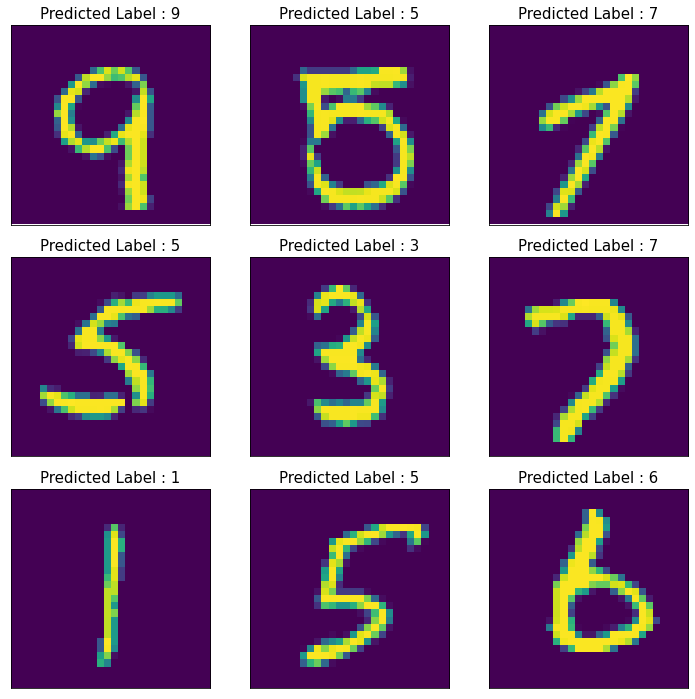

In [20]:
data = enumerate(test_loader)
# Show Sample Predictions
fig = plt.figure(figsize=(10,10))
for i in range(9):
    _, (images, labels) = next(data)
    idx = np.random.randint(0, P.batch_size, 1)
    lr_model.eval()
    prediction = lr_model(images[idx].view(-1, 28*28))
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(np.squeeze(images[idx]), cmap='viridis', interpolation='nearest')
    plt.title('Predicted Label : '+str(prediction.data.max(1, keepdim=True)[1].item()),fontsize=15)
    plt.xticks([])
    plt.yticks([])

### Neural Net

In [22]:
###################################### 
#             Neural NET             #
######################################
# 'class NN(nn.Module)' refers to the fact that this is a subclass of nn.Module and is inheriting all methods. 
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        # In the super class,nn.Module, there is a '__call__' method which obtains the forward function from 
        # the subclass and calls it
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.2)
        self.ReLU = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.ReLU(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [26]:
#create model instance
nn_model = NN(P.input_size, P.hidden_size, P.num_classes).to(device)

#define optimizer and criterion
optimizer = optim.Adam(nn_model.parameters(), P.learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

In [29]:
#Training
total_step = len(train_loader)
for epoch in range(P.num_epochs):
    data = enumerate(train_loader)
    prog_bar = tqdm(range(int(train_data.data.size(0)/P.batch_size)))
    for step in prog_bar: # iter over batches
        #move tnsors to the configured device
        i, (images, labels) = next(data)
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        #forward pass
        output = nn_model(images)
        loss = criterion(output, labels)
        
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Check point
        prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}' 
                                 .format(epoch+1, P.num_epochs, loss.item()))

Epoch 5/5, Loss: 0.0578: 100%|███████████████████████████████████████████████████████| 600/600 [00:19<00:00, 30.33it/s]


In [30]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
nn_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader: #doesn't matter if test_loader has batch_size > 1
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = nn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 97.62 %


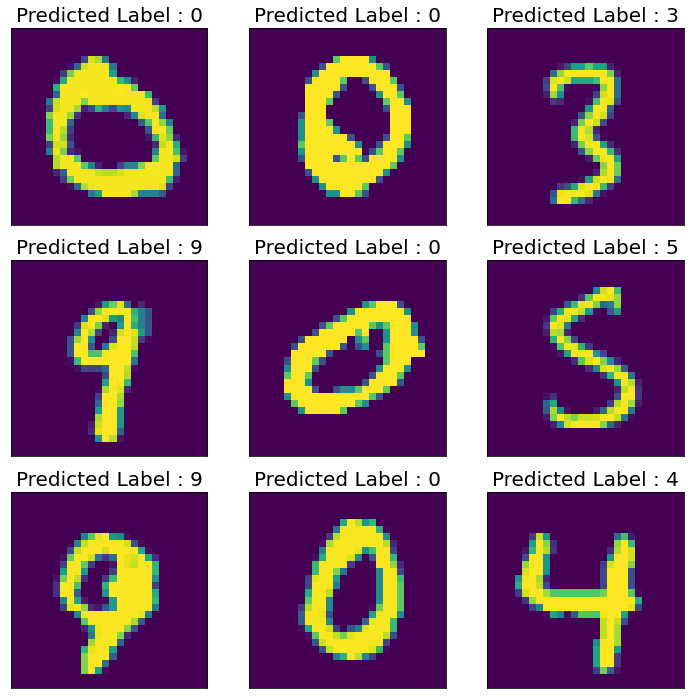

In [40]:
data = enumerate(test_loader)
# Show Sample Predictions
fig = plt.figure(figsize=(10,10))
for i in range(9):
    _, (img, labels) = next(data)
    nn_model.eval()
    prediction = nn_model(img.view(-1, 28*28))
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    idx = np.random.randint(0, P.batch_size, 1)
    plt.imshow(np.squeeze(img[idx]), cmap='viridis')
    plt.title('Predicted Label : '+str(prediction.data[idx].max(1, keepdim=True)[1].item()),fontsize=20)
    plt.xticks([])
    plt.yticks([])

### ConvNet

In [44]:
###################################### 
#          Convolutional Net         #
######################################
class ConvNet(nn.Module):
    def __init__(self, num_classes, input_shape=(1, 28, 28)):
        super(ConvNet, self).__init__()
        self.ch, self.h, self.w = input_shape
        self.layer1 = nn.Sequential(
            nn.Conv2d(self.ch, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.drpout = nn.Dropout(0.25)
        n_size = self._get_conv_output(input_shape)
        self.fc1 = nn.Linear(n_size, 50)
        self.fc2 = nn.Linear(50, num_classes)
        
#     # generate input sample and forward to get shape
#     def _get_conv_output(self, shape):
#         bs = 1
#         input = Variable(torch.rand(bs, *shape))
#         output_feat = self._forward_features(input)
#         n_size = output_feat.data.view(bs, -1).size(1)
#         return n_size
    
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drpout(out)
        out = self.fc2(out)
        return out

In [46]:
#create model instance
cnn_model = ConvNet(P.num_classes)

#define optimizer and criterion
optimizer = optim.Adam(cnn_model.parameters(), P.learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

In [48]:
#Training
total_step = len(train_loader)
cnn_model.train()

for epoch in range(P.num_epochs):
    data = enumerate(train_loader)
    prog_bar = tqdm(range(int(train_data.data.size(0)/P.batch_size)))
    for step in prog_bar: # iter over batches
        #move tnsors to the configured device
        i, (images, labels) = next(data)
        images = images.to(device)
        labels = labels.to(device)
        
        #forward pass
        output = cnn_model(images)
        loss = criterion(output, labels)
        
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
        #Check point
        prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}' 
                                 .format(epoch+1, P.num_epochs, loss.item()))

Epoch 5/5, Loss: 0.0044: 100%|███████████████████████████████████████████████████████| 600/600 [02:06<00:00,  4.73it/s]


In [49]:
# Test the model
cnn_model.eval() # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        output = cnn_model(image)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 98.77 %


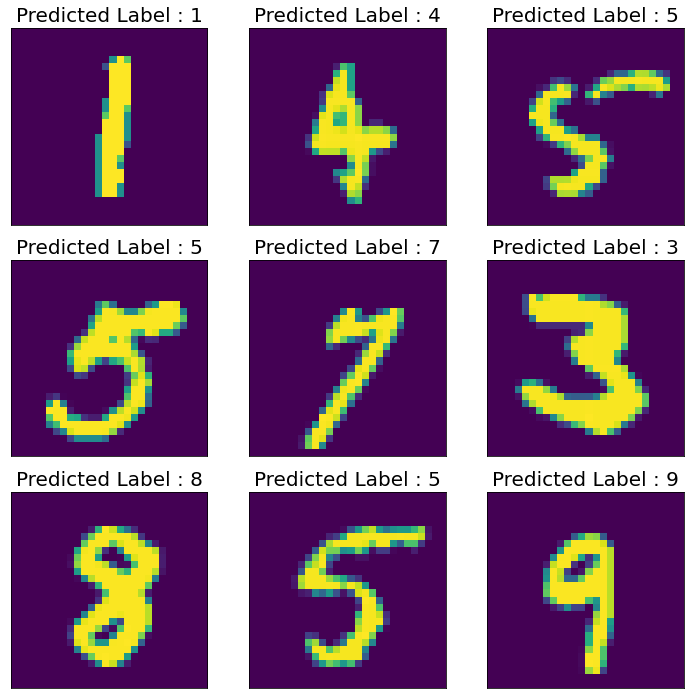

In [57]:
cnn_model.eval()
data = enumerate(test_loader)
# Show Sample Predictions
fig = plt.figure(figsize=(10,10))
for i in range(9):
    _, (images, labels) = next(data)
    idx = np.random.randint(0, P.batch_size, 1)
    prediction = cnn_model(images[idx])
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(np.squeeze(images[idx]), cmap='viridis')
    plt.title('Predicted Label : '+str(prediction.data.max(1, keepdim=True)[1].item()),fontsize=20)
    plt.xticks([])
    plt.yticks([])